In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import Dropout , Dense , InputLayer , Input

from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

# Loading data

In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [3]:
df = pd.read_csv("liver_cirrhosis.csv")
df2 = df.copy()
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,C,Placebo,18499,F,N,Y,N,N,0.5,149.0,4.04,227.0,598.0,52.70,57.0,256.0,9.9,1
1,1230,C,Placebo,19724,M,Y,N,Y,N,0.5,219.0,3.93,22.0,663.0,45.00,75.0,220.0,10.8,2
2,4184,C,Placebo,11839,F,N,N,N,N,0.5,320.0,3.54,51.0,1243.0,122.45,80.0,225.0,10.0,2
3,2090,D,Placebo,16467,F,N,N,N,N,0.7,255.0,3.74,23.0,1024.0,77.50,58.0,151.0,10.2,2
4,2105,D,Placebo,21699,F,N,Y,N,N,1.9,486.0,3.54,74.0,1052.0,108.50,109.0,151.0,11.5,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

In [5]:
df.isna().sum()

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

# Sprawdzanie zależności liniowej (corr i zrobiobienie z teog heatmap z sns)

# Checking imbalance of data (wykresy czy w stage nie ma za dużo jednego przykładu) wykres pie

# Rozwalanie Kolumn ze stringów na float/int

In [6]:
df.columns

Index(['N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')

### Rozwalanie kolumny status

In [7]:
# values to replace
columns = list(df.columns[1:3]) + list(df.columns[4:9] )
columns.append("Stage")
columns

['Status',
 'Drug',
 'Sex',
 'Ascites',
 'Hepatomegaly',
 'Spiders',
 'Edema',
 'Stage']

In [8]:
# tu będzie funckja która będzie cały nasz zbiór od razu przekształacała wszystkie stringi na liczby (Już stworzyłem)
def change_values(columns , dataframe):

    for column in columns:
        unique_values = dataframe[column].unique()
        dic = {d: k for k, d in enumerate(unique_values)} 
        print(column)
        print(dic)
        dataframe[column] = dataframe[column].replace(dic)

change_values(columns = columns , dataframe = df2)

Status
{'C': 0, 'D': 1, 'CL': 2}
Drug
{'Placebo': 0, 'D-penicillamine': 1}
Sex
{'F': 0, 'M': 1}
Ascites
{'N': 0, 'Y': 1}
Hepatomegaly
{'Y': 0, 'N': 1}
Spiders
{'N': 0, 'Y': 1}
Edema
{'N': 0, 'Y': 1, 'S': 2}
Stage
{1: 0, 2: 1, 3: 2}


In [9]:
df2['Status'].value_counts()

Status
0    13516
1     9456
2     2028
Name: count, dtype: int64

In [10]:
status_dic = {'C' : 0 , "D" : 1 , "CL" : 2}
df2['Status'] = df2['Status'].replace(status_dic)

### Rozwalanie kolumny Drug

In [11]:
df2['Drug'].value_counts()

Drug
0    15827
1     9173
Name: count, dtype: int64

In [12]:
drug_dic = {'Placebo' : 0 , "D-penicillamine" : 1}
df2['Drug'] = df2['Drug'].replace(drug_dic)

### Rozwalnie Sex , Ascites , Hepatomegaly , Spiders , Edema

In [13]:
df2['Sex'].value_counts()

Sex
0    22137
1     2863
Name: count, dtype: int64

In [14]:
unique = df2['Sex'].unique()
unique[0]

0

In [15]:
dic = {d: k for k, d in enumerate(unique)} 
df2["Sex"] = df2['Sex'].replace(dic)

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  int64  
 2   Drug           25000 non-null  int64  
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  int64  
 5   Ascites        25000 non-null  int64  
 6   Hepatomegaly   25000 non-null  int64  
 7   Spiders        25000 non-null  int64  
 8   Edema          25000 non-null  int64  
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

In [17]:
df2.Edema.value_counts()

Edema
0    20220
2     3698
1     1082
Name: count, dtype: int64

In [18]:
df2

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,2221,0,0,18499,0,0,0,0,0,0.5,149.000000,4.04,227.0,598.0,52.70,57.000000,256.0,9.9,0
1,1230,0,0,19724,1,1,1,1,0,0.5,219.000000,3.93,22.0,663.0,45.00,75.000000,220.0,10.8,1
2,4184,0,0,11839,0,0,1,0,0,0.5,320.000000,3.54,51.0,1243.0,122.45,80.000000,225.0,10.0,1
3,2090,1,0,16467,0,0,1,0,0,0.7,255.000000,3.74,23.0,1024.0,77.50,58.000000,151.0,10.2,1
4,2105,1,0,21699,0,0,0,0,0,1.9,486.000000,3.54,74.0,1052.0,108.50,109.000000,151.0,11.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3584,1,1,23612,0,0,1,0,0,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,1
24996,3584,1,1,23612,0,0,1,0,0,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0,1
24997,971,1,1,16736,0,0,0,1,1,5.1,369.510563,3.23,18.0,790.0,179.80,124.702128,104.0,13.0,2
24998,3707,0,1,16990,0,0,0,0,0,0.8,315.000000,4.24,13.0,1637.0,170.50,70.000000,426.0,10.9,1


# Making train/test datasets

In [19]:
y = df2["Stage"]
X = df2.drop(columns="Stage")

In [20]:
y

0        0
1        1
2        1
3        1
4        0
        ..
24995    1
24996    1
24997    2
24998    1
24999    1
Name: Stage, Length: 25000, dtype: int64

In [21]:
X

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
0,2221,0,0,18499,0,0,0,0,0,0.5,149.000000,4.04,227.0,598.0,52.70,57.000000,256.0,9.9
1,1230,0,0,19724,1,1,1,1,0,0.5,219.000000,3.93,22.0,663.0,45.00,75.000000,220.0,10.8
2,4184,0,0,11839,0,0,1,0,0,0.5,320.000000,3.54,51.0,1243.0,122.45,80.000000,225.0,10.0
3,2090,1,0,16467,0,0,1,0,0,0.7,255.000000,3.74,23.0,1024.0,77.50,58.000000,151.0,10.2
4,2105,1,0,21699,0,0,0,0,0,1.9,486.000000,3.54,74.0,1052.0,108.50,109.000000,151.0,11.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3584,1,1,23612,0,0,1,0,0,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0
24996,3584,1,1,23612,0,0,1,0,0,0.8,231.000000,3.87,173.0,9009.8,127.71,96.000000,295.0,11.0
24997,971,1,1,16736,0,0,0,1,1,5.1,369.510563,3.23,18.0,790.0,179.80,124.702128,104.0,13.0
24998,3707,0,1,16990,0,0,0,0,0,0.8,315.000000,4.24,13.0,1637.0,170.50,70.000000,426.0,10.9


In [52]:
# spliting data
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=411 , shuffle=True)

In [23]:
# Checking shapes
X_train.shape ,X_test.shape , y_train.shape, y_test.shape

((20000, 18), (5000, 18), (20000,), (5000,))

In [63]:
# Normalzing our data
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [64]:
X_train

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
13086,2.164706,0.003922,0.000000,81.925491,0.0,0.000000,0.000000,0.003922,0.000000,0.009020,0.698039,0.011765,0.568627,2.925490,0.699020,0.478431,0.478431,0.047059
1651,14.400000,0.000000,0.003922,55.317646,0.0,0.000000,0.003922,0.000000,0.000000,0.002745,0.800000,0.014353,0.109804,2.686275,0.285686,0.227451,1.211765,0.038039
2624,14.015686,0.003922,0.003922,96.411766,0.0,0.000000,0.003922,0.000000,0.000000,0.017647,1.449061,0.016039,0.382935,7.775121,0.480613,0.489028,1.615686,0.043529
11758,3.819608,0.003922,0.000000,85.898041,0.0,0.000000,0.000000,0.000000,0.000000,0.043137,2.643137,0.013922,1.403922,9.458823,0.656471,0.549020,0.866667,0.038431
6516,8.709804,0.000000,0.000000,72.545097,0.0,0.000000,0.000000,0.000000,0.000000,0.001961,0.584314,0.015843,0.890196,2.345098,0.206667,0.223529,1.003922,0.038824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,5.101961,0.007843,0.003922,74.400002,0.0,0.000000,0.000000,0.003922,0.007843,0.004314,1.694118,0.014000,0.176471,5.513725,0.745098,0.301961,0.647059,0.045490
18765,11.113726,0.000000,0.000000,74.482353,0.0,0.003922,0.003922,0.003922,0.000000,0.003529,1.449061,0.012314,0.382935,7.775121,0.480613,0.489028,0.749020,0.048235
20402,6.427451,0.000000,0.000000,84.509804,0.0,0.003922,0.003922,0.003922,0.000000,0.005098,1.449061,0.013333,0.382935,7.775121,0.480613,0.489028,0.952941,0.038039
4716,8.258823,0.000000,0.003922,85.599998,0.0,0.000000,0.000000,0.000000,0.000000,0.004314,1.286275,0.012980,0.623529,4.941176,0.370784,0.525490,0.709804,0.039608


In [65]:
y_train

13086    2
1651     1
2624     1
11758    1
6516     0
        ..
268      2
18765    0
20402    0
4716     1
7132     2
Name: Stage, Length: 20000, dtype: int64

In [66]:
y_train = to_categorical(y_train , num_classes=3)
#y_test = to_categorical(y_test , num_classes=3)

In [67]:
y_train

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [68]:
# Input shape for model
shape = (X_train.shape[1] , )
shape

(18,)

In [69]:
num_classes = len(np.unique(y_train))
print(num_classes) # xd ?

2


## Creating a model

In [70]:
def build_model():
    
    model = Sequential()
    
    model.add(InputLayer(shape=shape))
    model.add(Dense(256 , activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(128 , activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(64 , activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(32 , activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(3 , activation="softmax"))
    
    return model

In [71]:
model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,195 (188.26 KB)

 Trainable params: 48,195 (188.26 KB)

 Non-trainable params: 0 (0.00 B)

In [72]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001) , 
              loss = tf.keras.losses.CategoricalCrossentropy(),  
              metrics=["accuracy"])

In [73]:
# callbacks=[TQDMNotebookCallback()]
history = model.fit(x = X_train,
                   y = y_train ,
                   batch_size=64,
                   epochs=250 ,
                   validation_split=0.2,
                   shuffle=True,
                    verbose = 1
                   )

Epoch 1/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3312 - loss: 2.1075 - val_accuracy: 0.3417 - val_loss: 1.0890
Epoch 2/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3523 - loss: 1.1899 - val_accuracy: 0.3995 - val_loss: 1.0778
Epoch 3/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3553 - loss: 1.1463 - val_accuracy: 0.4642 - val_loss: 1.0759
Epoch 4/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3581 - loss: 1.1201 - val_accuracy: 0.4340 - val_loss: 1.0779
Epoch 5/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3712 - loss: 1.1061 - val_accuracy: 0.4857 - val_loss: 1.0668
Epoch 6/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3781 - loss: 1.0973 - val_accuracy: 0.4882 - val_loss: 1.0576
Epoch 7/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3937 - loss: 1.0850 - val_accuracy: 0.4803 - val_loss: 1.0506
Epoch 8/250
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3963 - loss: 1.0820 - val_accu

# Model evaluation

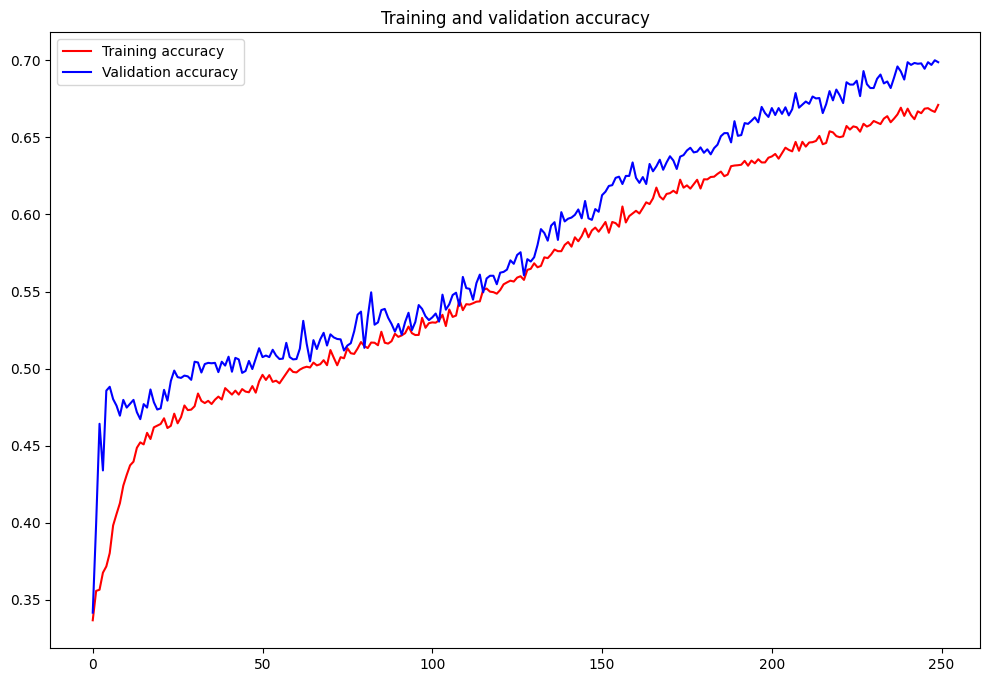

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))


plt.figure(figsize=(12, 8))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

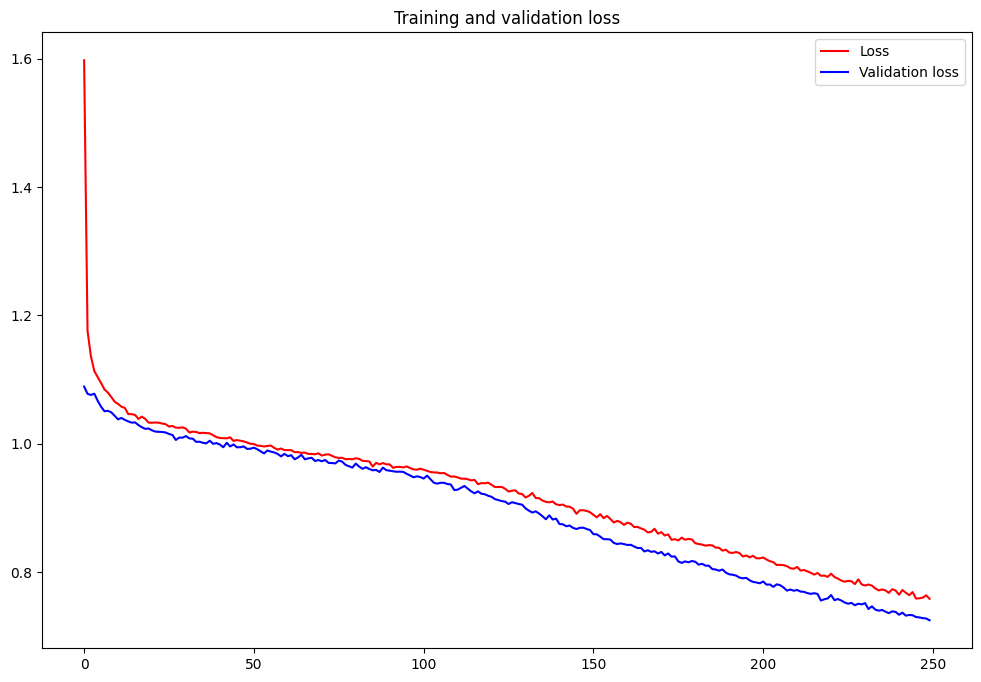

In [75]:
plt.figure(figsize=(12, 8))
plt.plot(epochs, loss, 'r', label='Loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Making predictions

In [76]:
def plot_classification(y_pred, y_true, model_name):
    num_matches = np.sum(y_pred == y_true)
    accuracy = num_matches / len(y_true)

    
    plt.figure(figsize=(20, 5))
    plt.scatter(range(len(y_pred)), y_pred, marker='o', c=y_true)
    plt.xlabel('Test Samples')
    plt.ylabel('Predicted Classes')
    plt.title('Classification via '+model_name)
    plt.show()

    print("Prediction accuracy: ", int(100 * accuracy) / 100)

In [77]:
x_pred = model.predict(X_test)
pred = np.argmax(x_pred , axis=1)
pred

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


array([1, 2, 1, ..., 1, 2, 1], dtype=int64)

In [78]:
y_test

15858    1
6569     2
7669     1
9335     2
8607     0
        ..
21934    2
20497    1
22637    0
19483    2
1226     1
Name: Stage, Length: 5000, dtype: int64

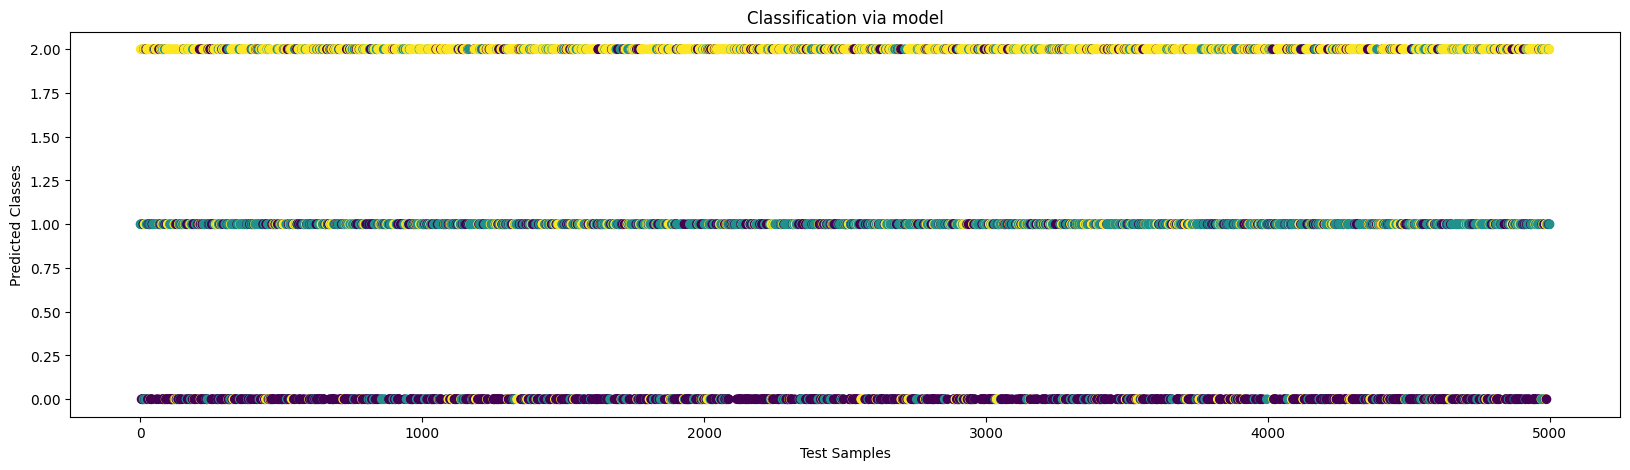

Prediction accuracy:  0.69


In [82]:
plot_classification(pred , y_test , "model")

# Confusion Matrix


In [80]:
def confusion_matrix(y_pred , y_true):        
    cm = tf.math.confusion_matrix(labels=y_true, predictions=y_pred)
    
    # Plot the confusion matrix as a heatmap.
    plt.figure(figsize=[12, 6])
    
    
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()

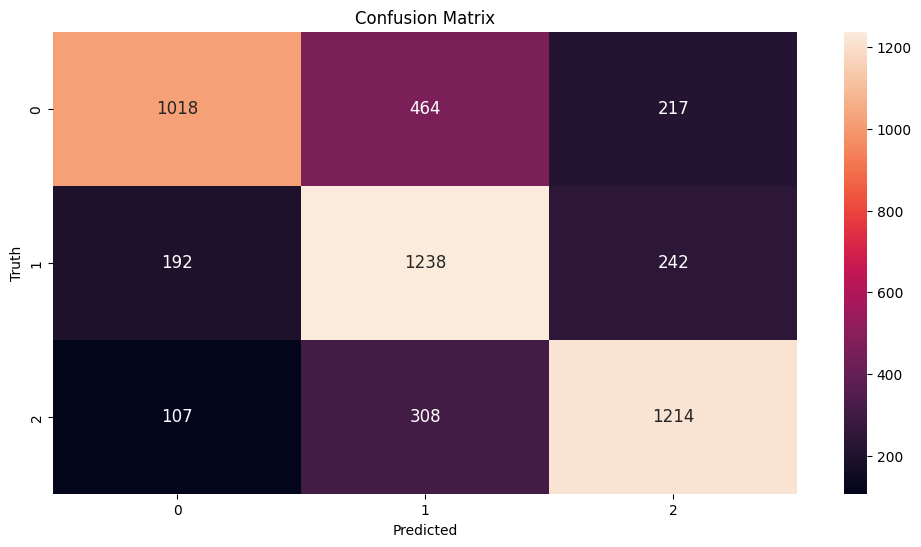

In [81]:
confusion_matrix(pred ,y_test)